In [ ]:
!pip install shap

In [ ]:
!pip install 'tensorflow==1.14.0'
!pip install keras==2.3.1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from modeling import FoldSet, GridSearch_ML, MLTest, RF_importances # ML
from rnn_modeling import Make_DataSet, Search_RNN, Model_RNN # RNN
from visualization import Result_pred, Monthly_plot, Hourly_plot, TimeBar, Correlation
from visualization import Plot_Result, Result_RNN

# Load data

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Train_Jd.csv')
print(df.shape)
df

(22447, 12)


,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Visibility,Time,Date,Area,Photovoltaics,Month
0,9.0,2.1,110.0,79.0,1024.1,0.0,2000.0,9,2015-01-25,전남 진도군,13680.0,1
1,10.4,3.0,110.0,77.0,1023.9,0.1,2000.0,10,2015-01-25,전남 진도군,115848.0,1
2,11.2,2.2,180.0,74.0,1023.9,0.0,2000.0,11,2015-01-25,전남 진도군,155016.0,1
3,12.6,1.9,180.0,71.0,1023.0,0.0,2000.0,12,2015-01-25,전남 진도군,175032.0,1
4,12.7,3.2,110.0,73.0,1021.7,0.0,2000.0,13,2015-01-25,전남 진도군,124560.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22442,0.4,1.6,50.0,80.0,1026.0,0.4,1991.0,13,2020-12-31,전남 진도군,210168.0,12
22443,1.6,4.0,320.0,78.0,1025.2,0.1,2000.0,14,2020-12-31,전남 진도군,84528.0,12
22444,2.0,4.4,270.0,67.0,1024.9,0.4,2000.0,15,2020-12-31,전남 진도군,122400.0,12
22445,1.6,5.4,320.0,75.0,1025.1,0.3,1755.0,16,2020-12-31,전남 진도군,129816.0,12


In [ ]:
df['Area'].unique()

array(['전남 진도군'], dtype=object)

In [ ]:
df['Date'].str[:4].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020'], dtype=object)

# Create Deviation Variable

In [ ]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Sunshine',
 'Visibility',
 'Photovoltaics']

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)



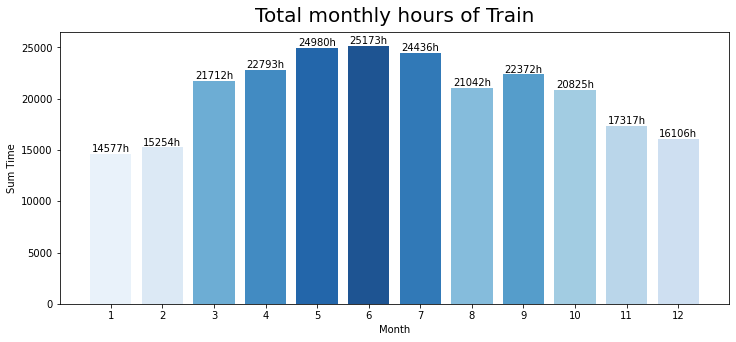

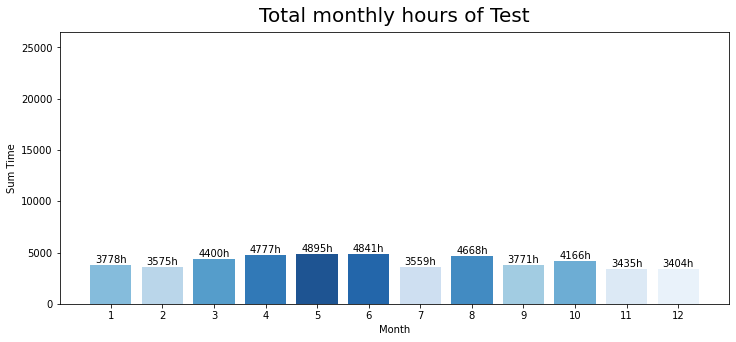

In [ ]:
TimeBar(df.loc[:18684-1], 'Train', 26500)
TimeBar(df.loc[18684:], 'Test', 26500)

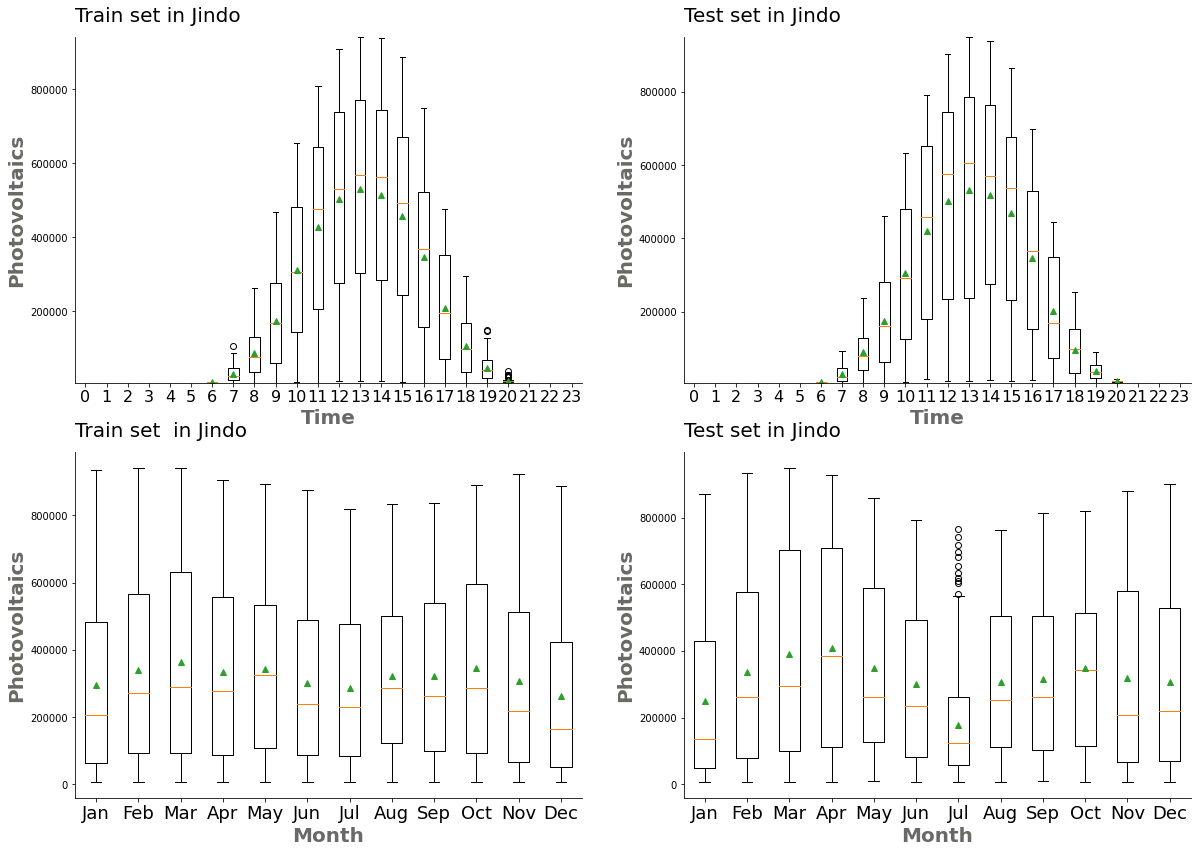

In [ ]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
Hourly_plot(df.loc[:18684-1], 'Photovoltaics', ax1, 'Train set in Jindo')
Monthly_plot(df.loc[:18684-1], 'Photovoltaics', ax3, 'Train set  in Jindo')
Hourly_plot(df.loc[18684:], 'Photovoltaics', ax2, 'Test set in Jindo')
Monthly_plot(df.loc[18684:], 'Photovoltaics', ax4, 'Test set in Jindo')

In [ ]:
train_Jd = pd.concat([x_train, y_train], axis=1)
train_Jd.columns

Index(['dev_Temperature', 'dev_Wind velocity', 'dev_Wind direction',
       'dev_Humidity', 'dev_Sea-level pressure', 'dev_Sunshine',
       'dev_Visibility', 'dev_Photovoltaics'],
      dtype='object')

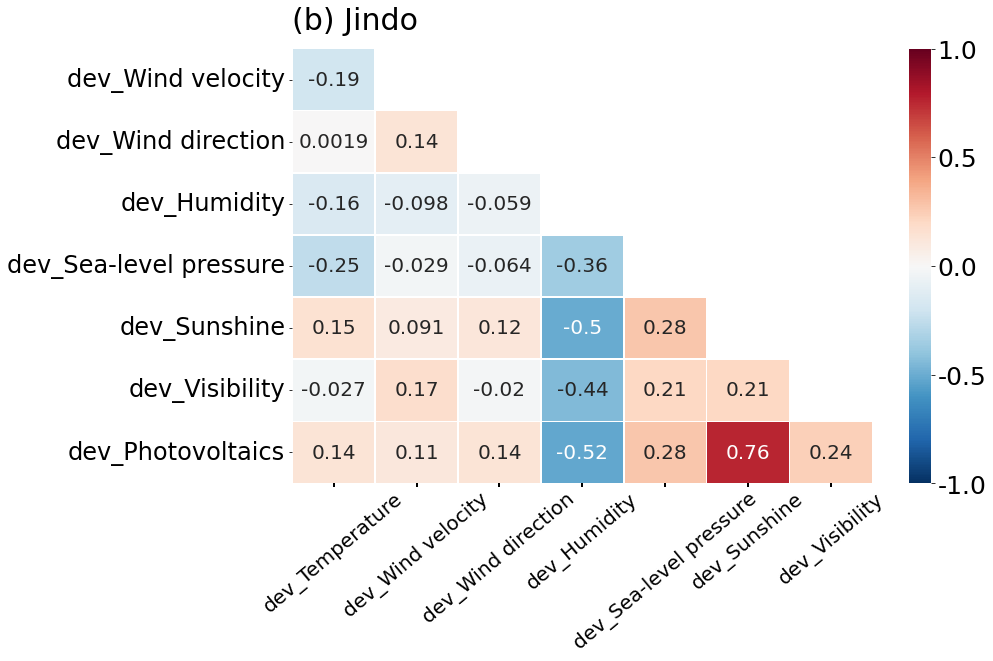

In [ ]:
fig, ax1 =  plt.subplots(figsize=(18, 12))
ax1.set_title('(b) Jindo', loc='left', y=1.03, fontsize=30)
c = Correlation(train_Jd, train_Jd.columns, ax1)
cbar = fig.get_children()[-1]
cbar.set_yticklabels([-1.00, -0.50, 0.00, 0.50, 1.00], fontsize=25)
fig.savefig('Jd_corr.png',  bbox_inches='tight', pad_inches=0, dpi=500)

# Fine-tuning the model

In [ ]:
params = {}

In [1]:
GridSearch_ML(df, cols, params, dev=True)
GridSearch_ML(df, cols, params, dev=False)
Search_RNN(df, params, 'LSTM', dev=True)
Search_RNN(df, params, 'GRU', dev=True)
Search_RNN(df, params, 'LSTM')
Search_RNN(df, params, 'GRU')

In [ ]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'max_iter': 4000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (500,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
dev_LSTM {'optimizer': 'Adam', 'epochs': 40, 'dropout': 0.4, 'dense_nparams': 128, 'batch_size': 16, 'activation': 'relu'}
dev_GRU {'optimizer': 'Adam', 'epochs': 35, 'dropout': 0.1, 'dense_nparams': 128, 'batch_size': 16, 'activation': 'relu'}
ori_LSTM {'optimizer': 'Adam', 'epochs': 35, 'dropout': 0.5, 'dense_nparams': 128, 'batch_size': 64, 'activation': 'relu'}
ori_GRU {'optimizer': 'Adam', 'epochs': 30, 'dropout': 0.2, 'dense_nparams': 64, 'batch_size': 64, 'activation

# Feature Importances

In [ ]:
importances = RF_importances(df, dev=False)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

explained varaiance : 0.6378140744094329
 MAPE : 1.075444779396788


In [ ]:
dev_importances = RF_importances(df, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

explained varaiance : 0.7732987515530332
 MAPE : 0.831712630968902


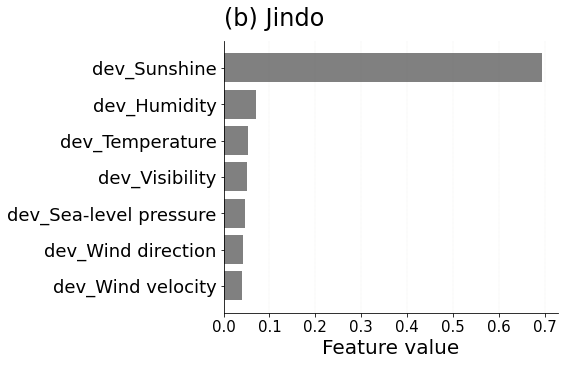

In [ ]:
fig, ax = plt.subplots(figsize=(10,8), ncols=1, nrows=1)
plt.title('(b) Jindo', loc='left', pad=15, fontsize=24)
pal = sns.color_palette('BuPu', n_colors=len(dev_importances.keys()))
ax.barh(y=range(0, len(dev_importances.keys())), width=dev_importances.values(), color='grey')
ax.set_yticklabels(labels=list(dev_importances.keys()), fontsize=18)
ax.set_yticks(range(0, len(dev_importances.keys())))
ax.set_xticklabels(np.round(np.arange(0, 1.0, 0.1),1), fontsize=15)
ax.set_xlabel('Feature value', fontsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(axis='x', color='#696965', linewidth=0.1, linestyle=':')
plt.savefig('Jd_features.png', bbox_inches='tight', dpi=500)
plt.show()

# Model Learning & SHAP

## LR 
- LinearRegression

In [ ]:
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

  shap.summary_plot(shap_values, x_train, plot_size=0.3, show=False)
  plt.xlabel('SHAP value', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

In [ ]:
def Shap_RNN(shap_model, train_X, model, cols):
  tf.compat.v1.keras.backend.get_session(op_input_list=())
  
  explainer = shap.GradientExplainer(model = shap_model, data = train_X)
  shap_values = explainer.shap_values(train_X)

  shap_values_2D = shap_values[0].reshape(-1,7)
  X_train_2D = train_X.reshape(-1,7)

  shap.summary_plot(shap_values_2D, X_train_2D, cols, plot_size=0.3, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()
  
  shap.summary_plot(shap_values_2D, X_train_2D, cols, plot_size=0.3, show=False, color='grey')
  plt.xlabel('SHAP value', fontsize=11, color='#696965', fontweight='semibold')
  plt.show()

In [ ]:
# score점수 저장
score = {}
ori_score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [ ]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

LinearRegression()


Exact explainer: 18685it [03:55, 76.37it/s]                            


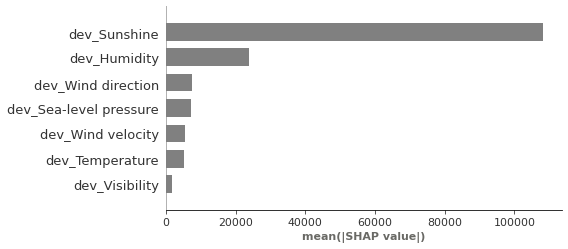

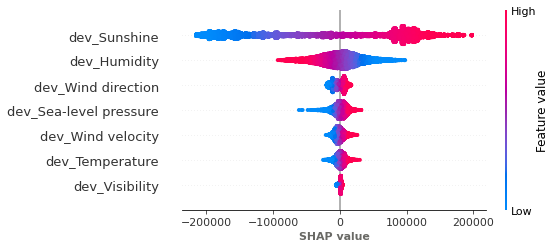

In [ ]:
ShapPlot(**Shap_dic['dev_LR'])

In [ ]:
LR = MLTest(df, 'LR', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

LinearRegression()


## MLP 
- Multi-Layer Perceptron regressor

In [ ]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)



Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(500,),
             learning_rate='adaptive', max_iter=4000)


Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.


Exact explainer: 18685it [1:10:06,  4.43it/s]


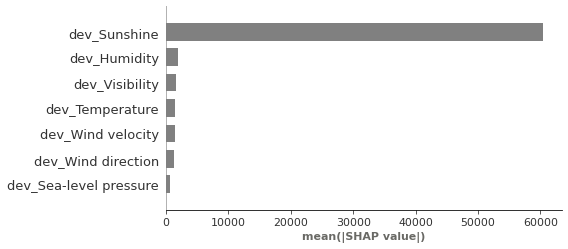

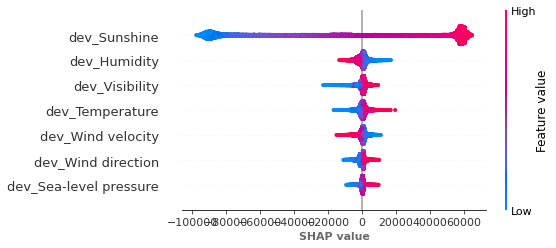

In [ ]:
ShapPlot(**Shap_dic['dev_MLP'])

In [ ]:
MLP = MLTest(df, 'MLP', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)



Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


MLPRegressor(activation='logistic', hidden_layer_sizes=(500,),
             learning_rate='adaptive', max_iter=3000)


Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.


## LGBM
 - Light Gradient Boosting Model regressor

In [ ]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)

train: (3114, 7), (3114, 1) valid: (3114, 7), (3114, 1)

train: (6228, 7), (6228, 1) valid: (3114, 7), (3114, 1)

train: (9342, 7), (9342, 1) valid: (3114, 7), (3114, 1)

train: (12456, 7), (12456, 1) valid: (3114, 7), (3114, 1)

train: (15570, 7), (15570, 1) valid: (3114, 7), (3114, 1)



Exact explainer: 18685it [15:12, 20.24it/s]


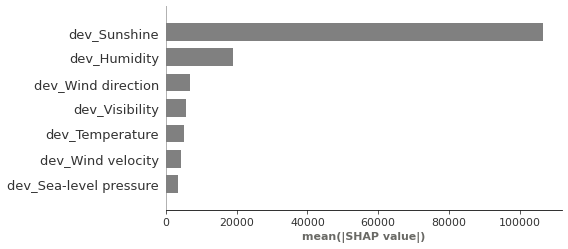

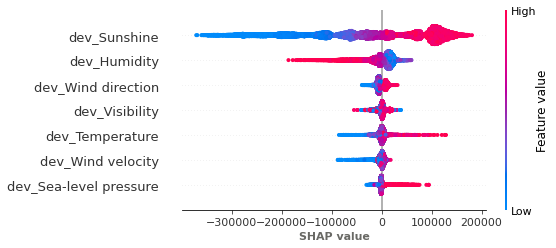

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [ ]:
LGBM = MLTest(df, 'LGBM', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)



## RNN Models
(Recurrent Neural Network)

- LSTM (Long Short-Term Memory)

In [ ]:
pred_LSTM = Model_RNN(df, 'LSTM', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18664, 20, 7), (18664, 1) test: (3743, 20, 7), (3743, 1)


train_set : (3114, 20, 7), valid_set : (3110, 20, 7)



train_set : (6224, 20, 7), valid_set : (3110, 20, 7)

train_set : (9334, 20, 7), valid_set : (3110, 20, 7)

train_set : (12444, 20, 7), valid_set : (3110, 20, 7)

train_set : (15554, 20, 7), valid_set : (3110, 20, 7)


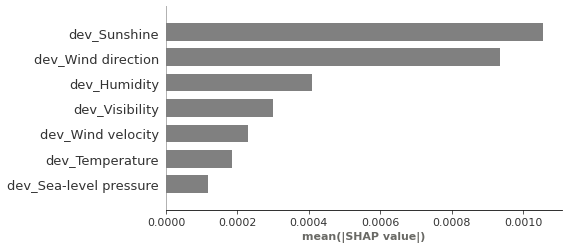

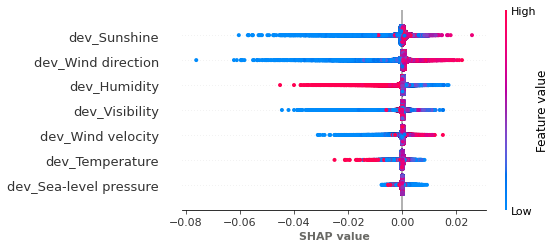

In [ ]:
Shap_RNN(**Shap_dic['dev_LSTM'])

In [ ]:
LSTM = Model_RNN(df, 'LSTM', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18664, 20, 7), (18664, 1) test: (3743, 20, 7), (3743, 1)


train_set : (3114, 20, 7), valid_set : (3110, 20, 7)

train_set : (6224, 20, 7), valid_set : (3110, 20, 7)

train_set : (9334, 20, 7), valid_set : (3110, 20, 7)

train_set : (12444, 20, 7), valid_set : (3110, 20, 7)

train_set : (15554, 20, 7), valid_set : (3110, 20, 7)


- GRU (Gated Recurrent Unit)

In [ ]:
pred_GRU = Model_RNN(df, 'GRU', params, score, Shap_dic, dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18664, 20, 7), (18664, 1) test: (3743, 20, 7), (3743, 1)


train_set : (3114, 20, 7), valid_set : (3110, 20, 7)

train_set : (6224, 20, 7), valid_set : (3110, 20, 7)

train_set : (9334, 20, 7), valid_set : (3110, 20, 7)

train_set : (12444, 20, 7), valid_set : (3110, 20, 7)

train_set : (15554, 20, 7), valid_set : (3110, 20, 7)


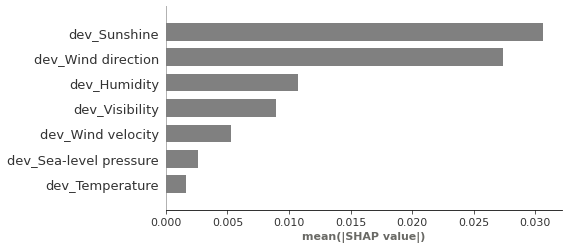

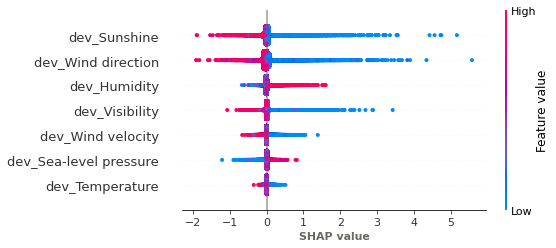

In [ ]:
Shap_RNN(**Shap_dic['dev_GRU'])

In [ ]:
GRU = Model_RNN(df, 'GRU', params, ori_score, Shap_dic)

Train-set:  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Sunshine, Visibility Index(['Photovoltaics'], dtype='object')
train: (18664, 20, 7), (18664, 1) test: (3743, 20, 7), (3743, 1)


train_set : (3114, 20, 7), valid_set : (3110, 20, 7)

train_set : (6224, 20, 7), valid_set : (3110, 20, 7)

train_set : (9334, 20, 7), valid_set : (3110, 20, 7)

train_set : (12444, 20, 7), valid_set : (3110, 20, 7)

train_set : (15554, 20, 7), valid_set : (3110, 20, 7)


# Score

In [ ]:
score

{'EVS_dev_LR': 0.793925862850171,
 'MAPE_dev_LR': 0.9412629147500653,
 'EVS_dev_MLP': 0.6900204138687024,
 'MAPE_dev_MLP': 0.9253541791602132,
 'EVS_dev_LGBM': 0.7789937217539469,
 'MAPE_dev_LGBM': 0.8274905247949578,
 'EVS_dev_LSTM': 0.47885210872895023,
 'MAPE_dev_LSTM': 1.1691965429212048,
 'EVS_dev_GRU': 0.4788523916109003,
 'MAPE_dev_GRU': 1.1691940688135691}

In [ ]:
ori_score

{'EVS_LR': 0.6049090803136183,
 'MAPE_LR': 1.3145143820454996,
 'EVS_MLP': 8.060219158778636e-14,
 'MAPE_MLP': 1.2627245124363353,
 'EVS_LGBM': 0.6589525871436686,
 'MAPE_LGBM': 1.0826770208664311,
 'EVS_LSTM': 0.002241953951255371,
 'MAPE_LSTM': 0.8503215675137737,
 'EVS_GRU': 0.04174388673621232,
 'MAPE_GRU': 0.8364362423514501}

# SHAP of best model
- 가장 성능이 좋은 모델의 shap과 상위 요소들간의 관계

In [ ]:
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  plt.title('(b) Jindo', loc='left', pad=15, fontsize=20)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, plot_type='bar', show=False, color='grey')
  plt.xlabel('mean(|SHAP value|)', fontsize=12, color='#696965', fontweight='semibold')
  plt.savefig('shap1_Jindo.png', bbox_inches='tight', dpi=500)
  plt.show()

  plt.title('(d) Jindo', loc='left', pad=15, fontsize=20)
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.xlabel('SHAP value', fontsize=12, color='#696965', fontweight='semibold')
  plt.savefig('shap2_Jindo.png', bbox_inches='tight', dpi=500)
  plt.show()

Exact explainer: 18685it [14:55, 20.73it/s]                           


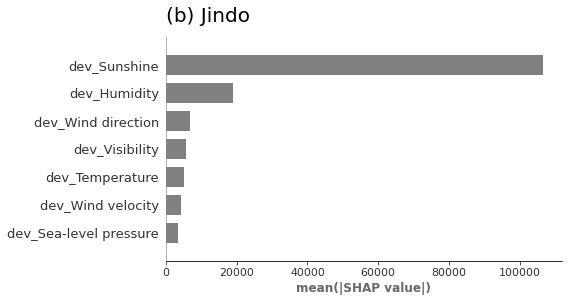

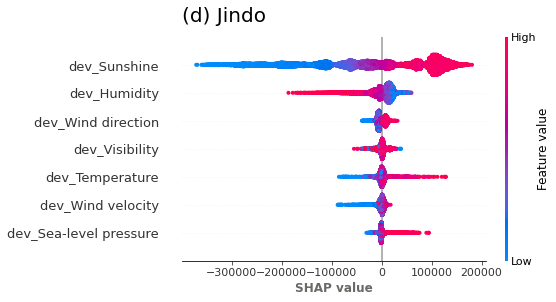

In [ ]:
ShapPlot(**Shap_dic['dev_LGBM'])

In [ ]:
def Shap_feature(model, x_train, model_name, col1, col2):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)
  shap.plots.scatter(shap_values[:,col1], color=shap_values[:,col2], show=False) 
  plt.title('(b) Jindo', loc='left', pad=15, fontsize=20)
  plt.savefig('shap_variable_Mokpo.png', bbox_inches='tight', dpi=500)
  plt.show()

Exact explainer: 18685it [14:47, 20.81it/s]                           


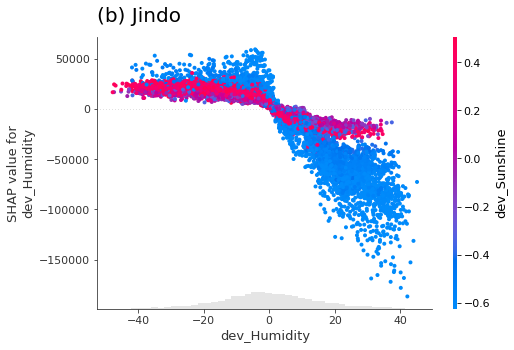

In [ ]:
Shap_feature(**Shap_dic['dev_LGBM'], col1='dev_Humidity', col2='dev_Sunshine') 

# Result save

In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'RNN', dev = True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18664, 20, 7), (18664, 1) test: (3743, 20, 7), (3743, 1)



In [ ]:
df_lstm = pd.DataFrame(pred_LSTM)
df_gru = pd.DataFrame(pred_GRU)
pred_rnn = pd.concat([df_lstm, df_gru], axis=1)

In [ ]:
pred_cols = ['PV', 'LSTM_Pred', 'GRU_Pred', 'train_mean']
df_RNN = Result_RNN(df, y_test, pred_rnn, testmn, pred_cols)
df_RNN

,Area,Date,Month,Time,PV,LSTM_Pred,GRU_Pred,train_mean
0,전남 진도군,2020-01-03,1,10,222840.0,164703.491829,164703.146528,164703.443478
1,전남 진도군,2020-01-03,1,11,417096.0,344846.612324,344845.790980,344846.571429
2,전남 진도군,2020-01-03,1,12,578808.0,458093.093319,458092.615283,458093.052632
3,전남 진도군,2020-01-03,1,13,545112.0,515935.968497,515935.482473,515935.928571
4,전남 진도군,2020-01-03,1,15,615240.0,435475.325950,435474.854251,435475.285714
...,...,...,...,...,...,...,...,...
3738,전남 진도군,2020-12-31,12,13,210168.0,448955.277910,448954.444546,448955.234043
3739,전남 진도군,2020-12-31,12,14,84528.0,426334.060399,426332.516501,426334.029851
3740,전남 진도군,2020-12-31,12,15,122400.0,344914.961724,344914.274824,344914.925373
3741,전남 진도군,2020-12-31,12,16,129816.0,163460.163490,163459.755962,163460.117647


In [ ]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Sunshine, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (18684, 7), (18684, 1) test: (3763, 7), (3763, 1)



In [ ]:
df_ML = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)
df_ML.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)
df_ML

,Area,Date,Month,Time,PV,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 진도군,2020-01-01,1,9,32184.0,11484.566656,32041.124100,40787.397998,36895.058824
1,전남 진도군,2020-01-01,1,10,178056.0,316244.050778,236384.731490,276354.712094,164703.443478
2,전남 진도군,2020-01-01,1,11,465264.0,501587.557636,416527.873421,452365.512559,344846.571429
3,전남 진도군,2020-01-01,1,12,517824.0,575837.823548,529681.275023,587931.332849,458093.052632
4,전남 진도군,2020-01-01,1,13,559800.0,575529.797060,548040.549415,578735.320778,515935.928571
...,...,...,...,...,...,...,...,...,...
3758,전남 진도군,2020-12-31,12,13,210168.0,318714.426056,396722.642982,393305.423199,448955.234043
3759,전남 진도군,2020-12-31,12,14,84528.0,260168.546460,344301.237016,259483.328997,426334.029851
3760,전남 진도군,2020-12-31,12,15,122400.0,253830.562694,274956.089458,296571.149365,344914.925373
3761,전남 진도군,2020-12-31,12,16,129816.0,55054.503875,83870.464037,67818.913687,163460.117647


In [ ]:
df_ML.to_csv('/content/gdrive/MyDrive/SolarPower/Jindo_ML.csv')
df_RNN.to_csv('/content/gdrive/MyDrive/SolarPower/Jindo_RNN.csv')